## Sandbox for thesis code

In [ ]:
# set path
import importlib
import sys, os
sys.path.append(os.path.abspath(".."))

import requests
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap

from src.auxilaries import retrieve_data_from_api ,month_id_to_ym, date_to_month_id

from sklearn.ensemble import RandomForestRegressor

Step 1: Import sample dataset from VIEWS to use for testing

In [2]:
api_url = "https://api.viewsforecasting.org"
loa = "cm"

fat_002_run = "predictors_fatalities002_2025_12"

And retrieve data for the full range.

In [24]:
fat_002_data = retrieve_data_from_api(fat_002_run, loa, verbose=True)

And save as pickle file

In [ ]:
with open("../data/raw/fat_002_data.pkl", "wb") as f:
    pkl.dump(fat_002_data, f)

## Test with basic random forest algorithm

In [59]:
with open("../data/raw/fat_002_data.pkl", "rb") as f:
    views_data = pkl.load(f)

In [60]:
views_data.columns

Index(['country_id', 'month_id', 'name', 'gwcode', 'isoab', 'year', 'month',
       'wb_wdi_sp_dyn_le00_in', 'wb_wdi_sp_dyn_imrt_in', 'wb_wdi_sp_pop_totl',
       'wb_wdi_se_prm_nenr', 'ucdp_ged_sb_best_sum', 'ucdp_ged_ns_best_sum',
       'vdem_v2x_rule', 'wb_wdi_ny_gdp_pcap_kd', 'ucdp_ged_os_best_sum',
       'vdem_v2x_libdem', 'vdem_v2x_gender', 'vdem_v2x_civlib',
       'vdem_v2xcl_acjst', 'vdem_v2xeg_eqdr'],
      dtype='str')

In [61]:
# make list of features
feature_list = [
   'wb_wdi_sp_dyn_le00_in', 'wb_wdi_sp_dyn_imrt_in', 'wb_wdi_sp_pop_totl',
    'ucdp_ged_sb_best_sum', 'ucdp_ged_ns_best_sum',
    'vdem_v2x_rule', 'wb_wdi_ny_gdp_pcap_kd', 'ucdp_ged_os_best_sum',
    'vdem_v2x_libdem', 'vdem_v2x_gender', 'vdem_v2x_civlib',
    'vdem_v2xcl_acjst', 'vdem_v2xeg_eqdr'
] 
target = "ucdp_ged_sb_best_sum"

## Test with Class structure

In [62]:
from src import dynamic
from src import auxilaries
importlib.reload(dynamic)
importlib.reload(auxilaries)
from src.auxilaries import date_to_month_id, month_id_to_ym
from src.dynamic import DynamicModel, DynamicModelManager

In [63]:
full_model = DynamicModelManager(
    steps = [3],
    data = views_data,
    features = feature_list,
    target = target,
    train_window_size=120,
    test_window_size=12,
    slide_window_size = 12,
    full_split = (121, 528)
)

In [64]:
full_model.fit()

Fitting models: 100%|██████████| 24/24 [02:46<00:00,  6.94s/it]

Finished fitting all models in 166.45 seconds


In [65]:
full_model.predict(data = views_data)

Predicting: 100%|██████████| 552/552 [00:08<00:00, 63.84it/s]


In [66]:
actuals = views_data[["country_id", "month_id", "ucdp_ged_sb_best_sum"]]

In [67]:
rows = []

for prediction in full_model.predictions:
    row = {
        "train_start": prediction.train_split.start_month,
        "train_end": prediction.train_split.end_month,
        "train_step": prediction.train_split.step,
        "test_start": prediction.test_split.start_month,
        "test_end": prediction.test_split.end_month,
        "test_step": prediction.test_split.step,
        "mse": prediction.mse(actuals),
        "msle": prediction.msle(actuals),
        "distance": prediction.distance_
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

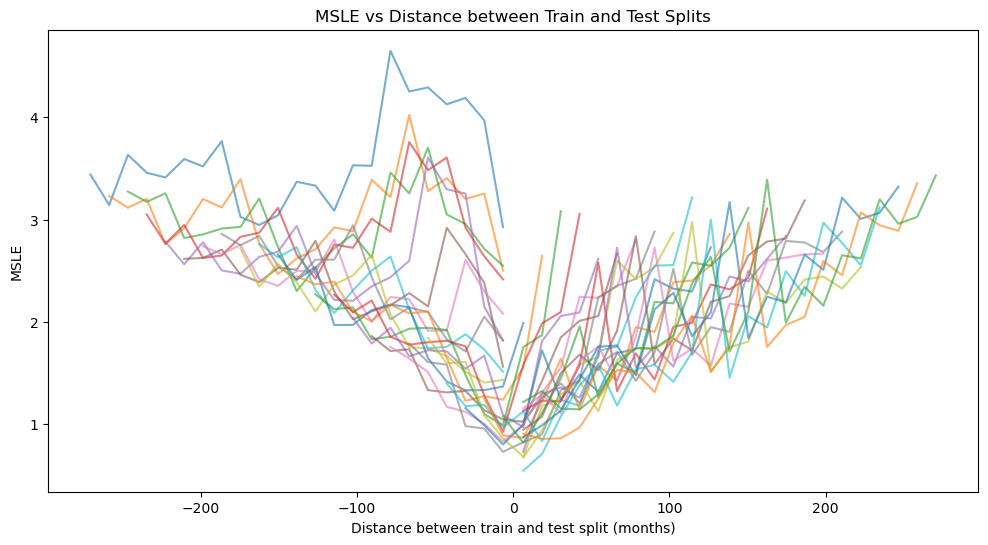

In [70]:
# plot mse and msle against distance, grouped by test_start
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for test_start, group in metrics_df.groupby("test_start"):
    plt.plot(group["distance"], group["msle"], label=f"test_start={test_start}", alpha=0.6)
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSLE")
plt.title("MSLE vs Distance between Train and Test Splits")
#plt.legend()
plt.show()

## Test with better dataset and more features

Read in joint_narrow dataset from VIEWSER

In [3]:
fat_data = pd.read_parquet("../data/raw/fatalities002_joint_narrow.parquet")

In [4]:
fat_data.reset_index(inplace=True,)

Define features and target (predict for log target this time)

In [5]:
fat_features = [
        'ln_ged_sb_dep', 'ln_ged_sb', 'reign_tenure_months',
       'wdi_sp_pop_totl', 'wdi_ag_lnd_frst_k2', 'wdi_nv_agr_totl_kn',
       'wdi_sh_sta_maln_zs', 'wdi_sl_tlf_totl_fe_zs', 'wdi_sm_pop_refg_or',
       'wdi_sp_dyn_imrt_in', 'wdi_sp_pop_14_fe_zs', 'wdi_sp_pop_grow',
       'vdem_v2xcl_dmove', 'vdem_v2xcl_rol', 'vdem_v2xeg_eqdr',
       'vdem_v2xpe_exlpol', 'vdem_v2xpe_exlsocgr', 'ln_ged_sb_tlag_1',
       'ln_ged_sb_tlag_2', 'splag_wdi_ag_lnd_frst_k2',
       'splag_wdi_sl_tlf_totl_fe_zs', 'splag_wdi_sm_pop_netm',
       'splag_vdem_v2xpe_exlsocgr', 'splag_vdem_v2xcl_rol', 'decay_ged_sb_5',
       'decay_ged_os_5', 'decay_acled_os_5', 'decay_ged_sb_100',
       'decay_ged_sb_500', 'splag_1_decay_ged_sb_5'
]
fat_target = "ln_ged_sb"

And make new Dynamic model:

In [29]:
fat_model = DynamicModelManager(
    steps = [12],
    data = fat_data,
    features = fat_features,
    target = fat_target,
    train_window_size=120,
    test_window_size=12,
    slide_window_size = 12,
    full_split = (156, 540) #restrict to 1990-2024 to avoid excess zeroes
)

Fit the models:

In [30]:
fat_model.fit()

Fitting models: 100%|██████████| 22/22 [05:57<00:00, 16.25s/it]

Finished fitting all models in 357.41 seconds


Predict:

In [31]:
fat_model.predict(data = fat_data)

Predicting: 100%|██████████| 682/682 [00:07<00:00, 93.65it/s] 


Define actuals:

In [32]:
actuals = fat_data[["country_id", "month_id", "ln_ged_sb"]]

In [ ]:
rows = []

for prediction in fat_model.predictions:
    row = {
        "train_start": prediction.train_split.start_month,
        "train_end": prediction.train_split.end_month,
        "train_step": prediction.train_split.step,
        "test_start": prediction.test_split.start_month,
        "test_end": prediction.test_split.end_month,
        "test_step": prediction.test_split.step,
        "mse": prediction.mse(actuals),
        "msle": prediction.msle(actuals),
        "distance": prediction.distance_
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

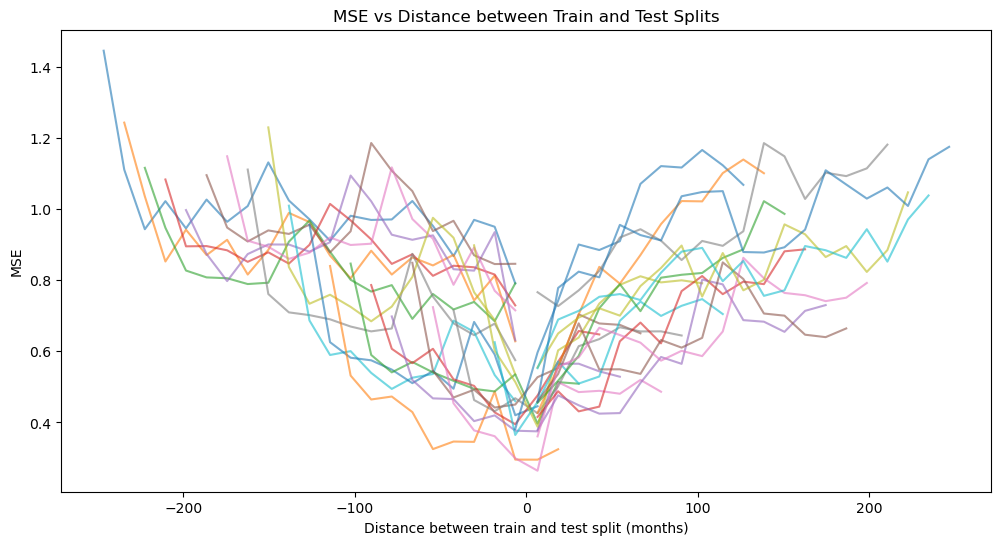

In [ ]:
# plot mse and msle against distance, grouped by test_start
metrics = metrics_df.copy()

step = 12
start = 325
plt.figure(figsize=(12, 6))
for (test_start, test_step), group in metrics.groupby(["test_start", "test_step"]):
        if test_step == step:
                plt.plot(group["distance"], group["mse"], label=f"test_start={test_start}, test_step={test_step}", alpha=0.6)
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSE")
plt.title("MSE vs Distance between Train and Test Splits")
#plt.legend()
plt.show()

In [48]:
# compute average mse and msle by test_average
metrics_avg = metrics_df.groupby("train_start").agg({"mse": "mean", "msle": "mean"}).reset_index()

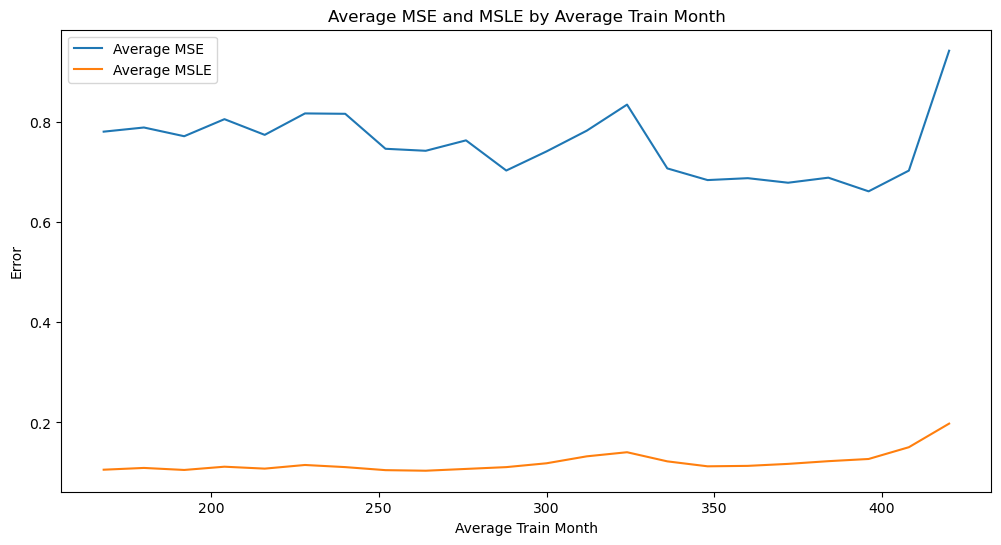

In [49]:
# plot average mse and msle against test_average
plt.figure(figsize=(12, 6))
plt.plot(metrics_avg["train_start"], metrics_avg["mse"], label="Average MSE")
plt.plot(metrics_avg["train_start"], metrics_avg["msle"], label="Average MSLE")
plt.xlabel("Average Train Month")
plt.ylabel("Error")
plt.title("Average MSE and MSLE by Average Train Month")
plt.legend()
plt.show()

## Vizualise train-test splits and predictions

In [57]:
def plot_all_train_test_layout(manager: DynamicModelManager):

    train_splits = manager.get_train_splits()
    test_splits = manager.get_test_splits()

    month_min, month_max = manager.full_split
    months = np.arange(month_min, month_max + 1)

    # Matrix: rows = train splits, columns = months
    layout = np.zeros((len(train_splits), len(months)))

    for i, train_split in enumerate(train_splits):

        for test_split in test_splits:

            # Only compare same step
            if test_split.step != train_split.step:
                continue

            if not manager._has_overlap(train_split, test_split):

                # mark test months as 1
                mask = (months >= test_split.start_month) & (months <= test_split.end_month)
                layout[i, mask] = 1

        # mark train months as 2 (optional highlight)
        train_mask = (months >= train_split.start_month) & (months <= train_split.end_month)
        layout[i, train_mask] = 2

    df = pd.DataFrame(layout, columns=months)

    plt.figure(figsize=(18, 10))

    cmap = ListedColormap(["grey", "lightblue", "maroon"])

    sns.heatmap(df, cmap=cmap, cbar=False)

    plt.xlabel("Month ID")
    plt.ylabel("Train Split Index")

    # add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='grey', label='No Data'),
        Patch(facecolor='lightblue', label='Test'),
        Patch(facecolor='maroon', label='Train')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Train/Test Split Structure Across All Models")
    plt.show()

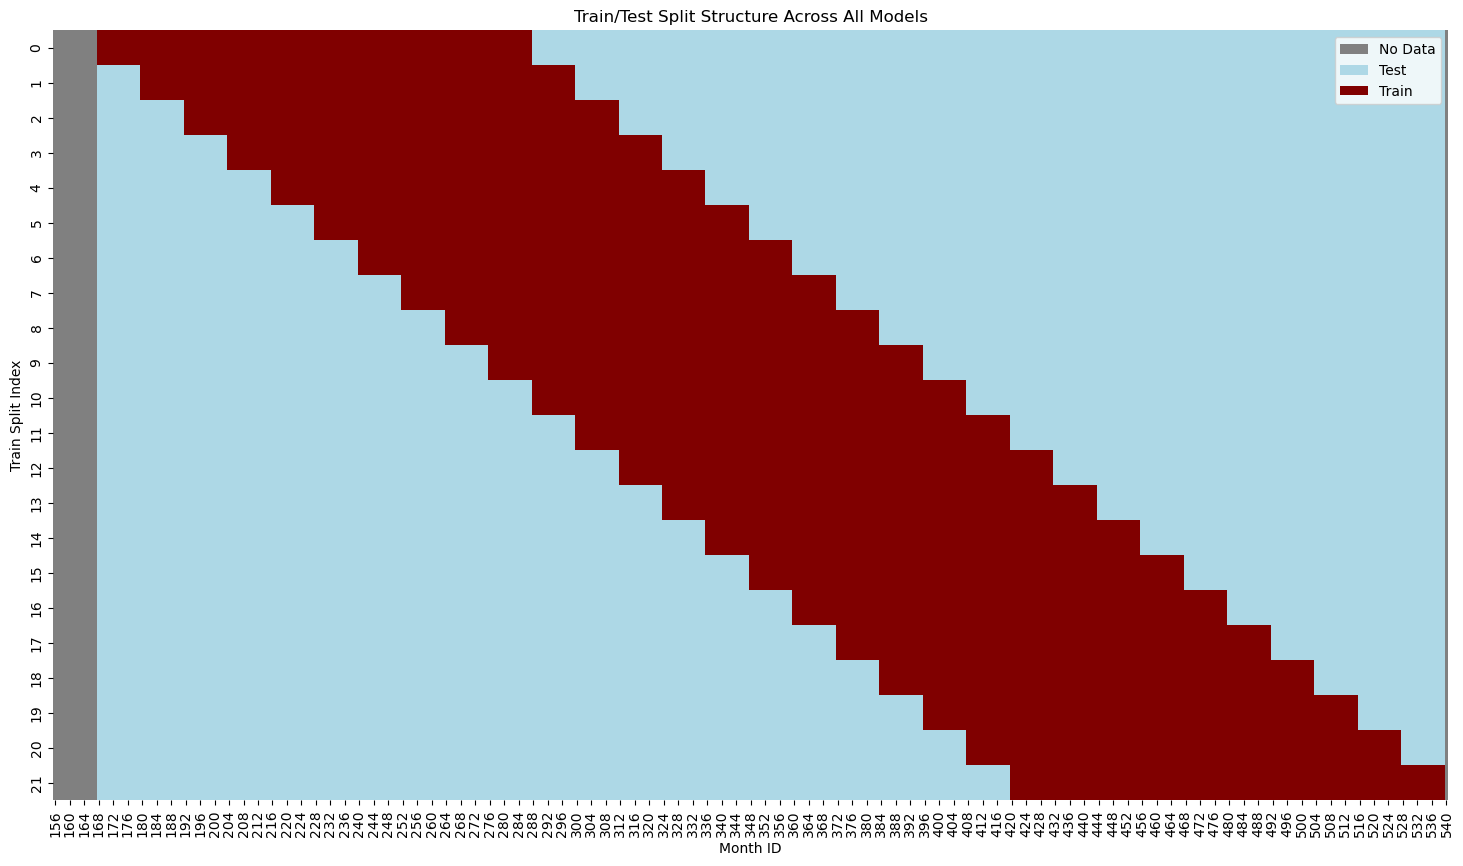

In [58]:
plot_all_train_test_layout(fat_model)

## Debug

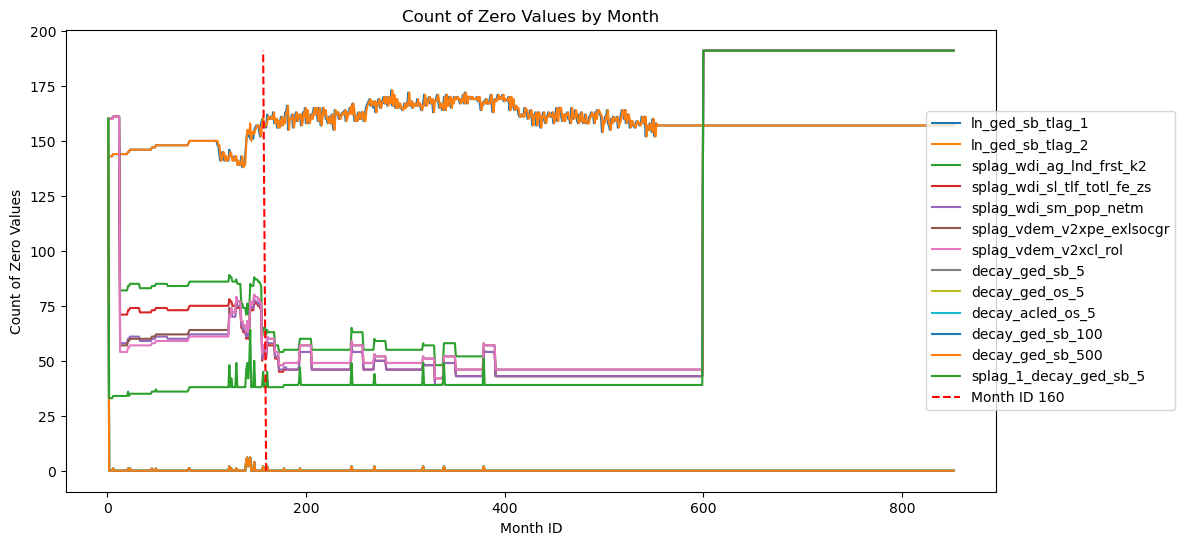

In [72]:
zero_counts = (
    fat_data
        .eq(0)                      # True where value == 0
        .groupby(fat_data["month_id"])
        .sum()
)

#columns_to_plot = [col for col in zero_counts.columns if col not in ["country_id", "month_id"]]
columns_to_plot = ['ln_ged_sb_tlag_1', 'ln_ged_sb_tlag_2',
       'splag_wdi_ag_lnd_frst_k2', 'splag_wdi_sl_tlf_totl_fe_zs',
       'splag_wdi_sm_pop_netm', 'splag_vdem_v2xpe_exlsocgr',
       'splag_vdem_v2xcl_rol', 'decay_ged_sb_5', 'decay_ged_os_5',
       'decay_acled_os_5', 'decay_ged_sb_100', 'decay_ged_sb_500',
       'splag_1_decay_ged_sb_5']

# plot zero counts over time
plt.figure(figsize=(12, 6))
for column in zero_counts.columns:
    if column in columns_to_plot:
        plt.plot(zero_counts.index, zero_counts[column], label=column)

# add vertical line for month_id 160
plt.plot([160, 157], [0, zero_counts.drop(columns=["country_id", "month_id"]).max().max()], color="red", linestyle="--", label="Month ID 160")
plt.xlabel("Month ID")
plt.ylabel("Count of Zero Values")
plt.title("Count of Zero Values by Month")
plt.legend(loc="right", bbox_to_anchor=(1.2, 0.5))
plt.show()